In [1]:
import matplotlib as plt
import sklearn as sklearn
import scipy as scipy
import pandas as pd
import numpy as np
import copy

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import functions as fun
from pointnetfunct.evaluation import show_cm_ml,draw_ROC_ml,print_values_advance


# Data Processing


In [3]:
import data_process_ml
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [4]:
class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

train_data_cat = copy.deepcopy(morpho_data_dome)
train_data_cat.drop(["status_ruptured"], axis=1, inplace=True)
data_num = list(train_data_cat)

num_pipeline= Pipeline([
    ('selector', DataFrameSelector(data_num)),
    ('imputer',SimpleImputer(strategy="mean")),
    ('stand_scalar',StandardScaler()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline)
])

data_prepared = full_pipeline.fit_transform(train_data_cat)

In [5]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
target_data_copy = morpho_data_dome["status_ruptured"].copy()

data_copy = morpho_data_dome.copy()
data_test = morpho_data_dome.copy()
data_copy = data_copy[:635]
data_test = data_test[635:]
print(len(data_copy),len(data_test))

train_set, test_set = train_test_split(data_copy , test_size= 0.20, random_state=42)

train_set_target = train_set["status_ruptured"].copy()
train_set.drop(("status_ruptured"),axis=1,inplace=True)

test_set_target = test_set["status_ruptured"].copy()
test_set.drop(("status_ruptured"),axis=1,inplace=True)

data_test_target = data_test["status_ruptured"].copy()
data_test.drop(("status_ruptured"),axis=1,inplace=True)

test_prepared = full_pipeline.fit_transform(test_set)
train_prepared = full_pipeline.fit_transform(train_set)
data_test_prepared = full_pipeline.fit_transform(data_test)


635 100


In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def prediction_conv (list_pred, value = 0.5):
    list_result = []
    for i in list_pred:
        if i >= value:
            list_result.append(1)
        else:
            list_result.append(0)
    return list_result

def show_cm_ml(data_predictions, test_set_target):
    #cm = confusion_matrix(list(test_set_target), data_predictions)
    cm = fun.dim4_cm(list(test_set_target), data_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred Unrupture","Pred uncertain Unrupture","Pred uncertain Rupture","Pred Rupture"], yticklabels=["Real Unrupture"," Real Rupture"])

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
from pointnetfunct.evaluation import print_values

import matplotlib.pyplot as plt
def draw_ROC (y_true_binary, y_pred_binary,name):
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)
    auc = roc_auc_score(y_true_binary, y_pred_binary)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + name )
    plt.legend(loc="lower right")
    plt.show()


    

# OLS

OLS internal test set Accuracy: 0.6771653543307087
OLS internal test set F1 score: 0.5060240963855422
OLS internal test set RMSE: 0.5681853972686127
OLS internal test set Rupture Recall: 0.525
OLS internal test set Rupture Precision: 0.4883720930232558
OLS internal test set UnRupture Recall: 0.7471264367816092
OLS internal test set UnRupture Precision: 0.7738095238095238


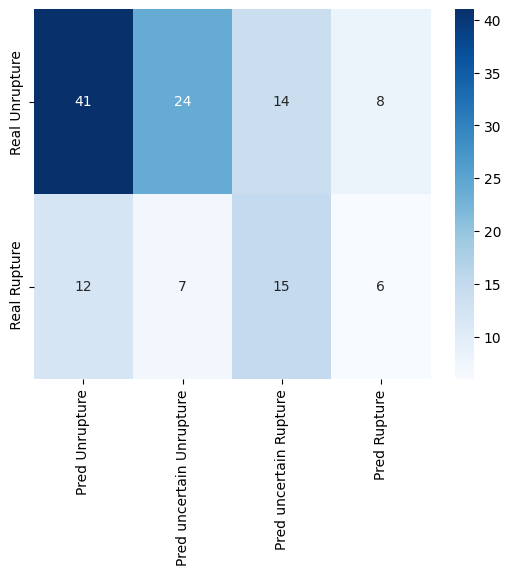

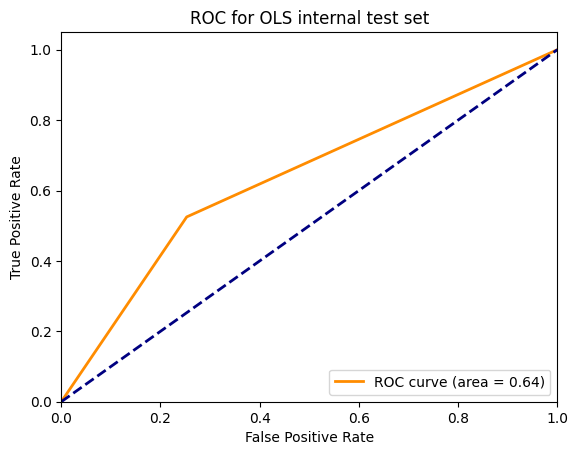

In [8]:

lin_reg=linear_model.LinearRegression()
lin_reg.fit(train_prepared,train_set_target)

data_predictions_raw = lin_reg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
print_values_advance( list(test_set_target), data_predictions,name="OLS internal test set")

show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "OLS internal test set")


OLS external test set Accuracy: 0.5
OLS external test set F1 score: 0.358974358974359
OLS external test set RMSE: 0.7071067811865476
OLS external test set Rupture Recall: 0.3181818181818182
OLS external test set Rupture Precision: 0.4117647058823529
OLS external test set UnRupture Recall: 0.6428571428571429
OLS external test set UnRupture Precision: 0.5454545454545454


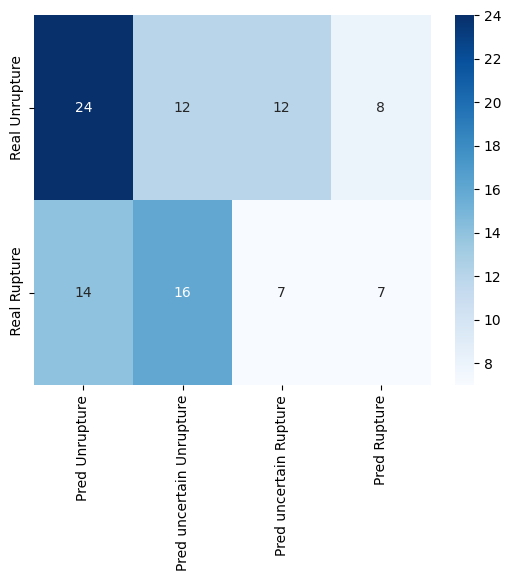

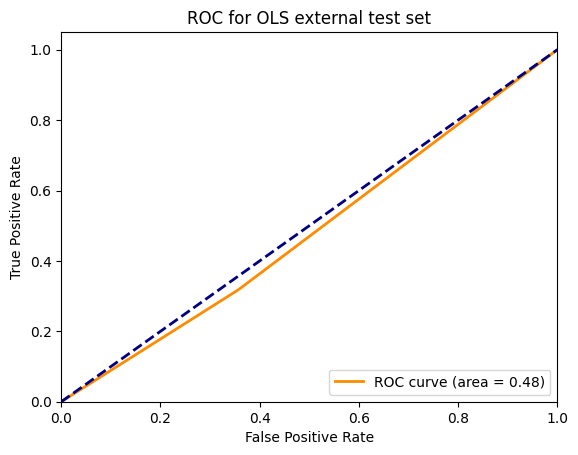

In [9]:
data_predictions_raw = lin_reg.predict(data_test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(data_test_target))
print_values_advance( list(data_test_target), data_predictions,name="OLS external test set")

show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "OLS external test set")

# Lasso and Ridge linear Regression

Lasso best alpha: 0.02
Lasso internal test set Accuracy: 0.7559055118110236
Lasso internal test set F1 score: 0.47457627118644063
Lasso internal test set RMSE: 0.4940591950252281
Lasso internal test set Rupture Recall: 0.35
Lasso internal test set Rupture Precision: 0.7368421052631579
Lasso internal test set UnRupture Recall: 0.9425287356321839
Lasso internal test set UnRupture Precision: 0.7592592592592593


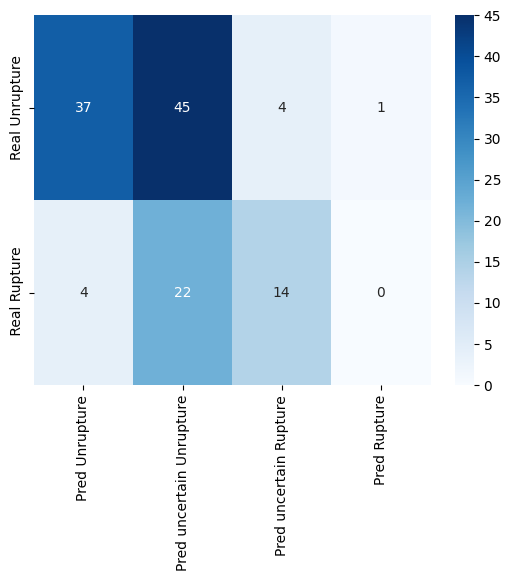

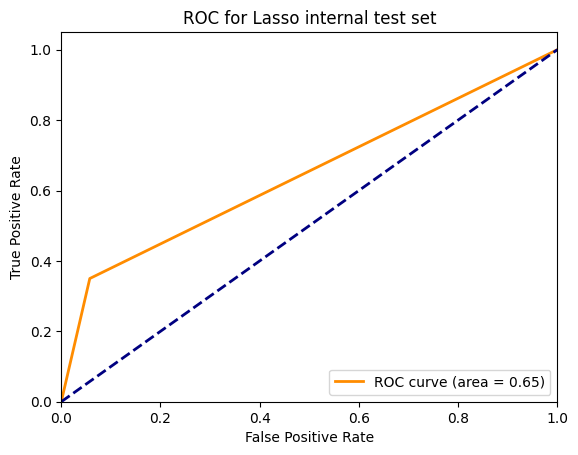

In [10]:
from sklearn.model_selection import GridSearchCV

#print(train_set_target)
model_cv = linear_model.LassoCV(alphas=list(np.arange(0.01,20,0.01)), cv=5).fit(train_prepared,train_set_target)
print("Lasso best alpha:",model_cv.alpha_)
las_reg_a = model_cv.alpha_
#las_reg_a = search.best_params_['model__alpha']
las_reg_a = 0.06

lasso_reg = linear_model.Lasso(alpha=las_reg_a)
lasso_reg.fit(train_prepared,train_set_target)

data_predictions_raw = lasso_reg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)

print_values_advance( list(test_set_target), data_predictions,name="Lasso internal test set")
show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "Lasso internal test set")



Lasso external test set Accuracy: 0.58
Lasso external test set F1 score: 0.25
Lasso external test set RMSE: 0.648074069840786
Lasso external test set Rupture Recall: 0.1590909090909091
Lasso external test set Rupture Precision: 0.5833333333333334
Lasso external test set UnRupture Recall: 0.9107142857142857
Lasso external test set UnRupture Precision: 0.5795454545454546


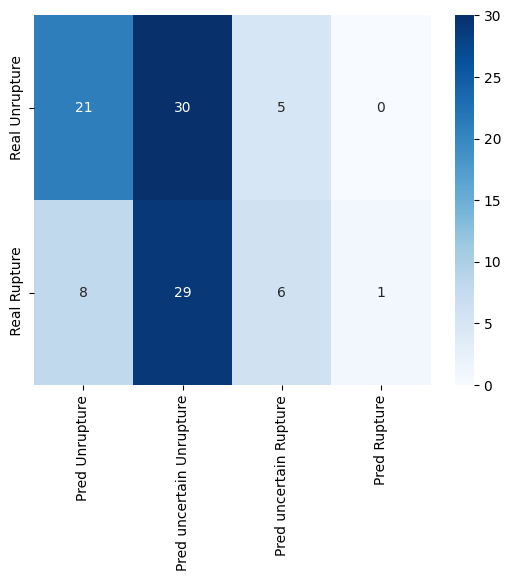

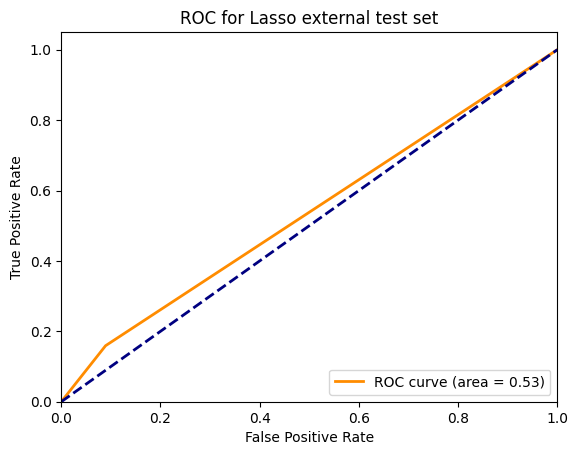

In [11]:
data_predictions_raw = lasso_reg.predict(data_test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(data_test_target))
print_values_advance( list(data_test_target), data_predictions,name="Lasso external test set")

show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "Lasso external test set")

Ridge best alpha: 99.9
Ridge internal test Accuracy: 0.7322834645669292
Ridge internal test F1 score: 0.5641025641025641
Ridge internal test RMSE: 0.5174133119983201
Ridge internal test Rupture Recall: 0.55
Ridge internal test Rupture Precision: 0.5789473684210527
Ridge internal test UnRupture Recall: 0.8160919540229885
Ridge internal test UnRupture Precision: 0.797752808988764


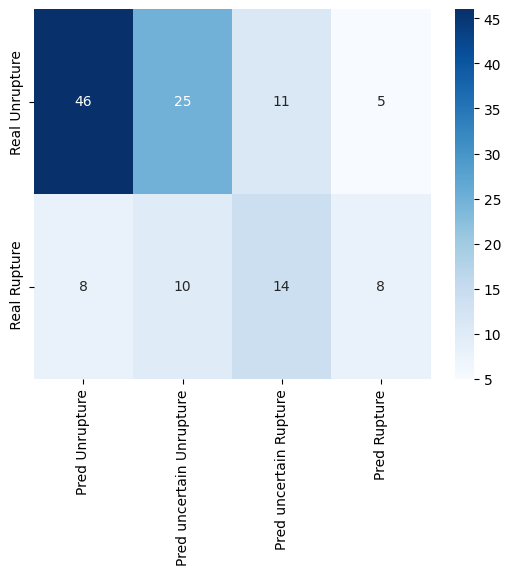

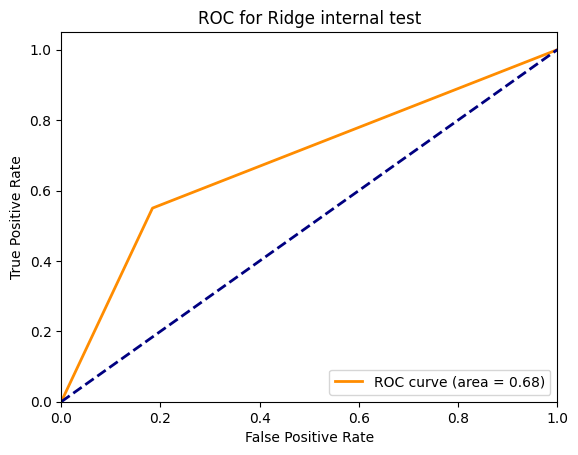

In [12]:
model_cv = linear_model.RidgeCV(alphas=list(np.arange(0.1,100,0.1)), cv=5).fit(train_prepared,train_set_target)
print("Ridge best alpha:",model_cv.alpha_)
ridge_reg_a = model_cv.alpha_
ridge_reg_a =19.7

ridge_reg = linear_model.Ridge(alpha=ridge_reg_a)
ridge_reg.fit(train_prepared,train_set_target)

data_predictions_raw = ridge_reg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)

print_values_advance( list(test_set_target), data_predictions,name="Ridge internal test")
show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "Ridge internal test")


Ridge external test Accuracy: 0.57
Ridge external test F1 score: 0.410958904109589
Ridge external test RMSE: 0.6557438524302001
Ridge external test Rupture Recall: 0.3409090909090909
Ridge external test Rupture Precision: 0.5172413793103449
Ridge external test UnRupture Recall: 0.75
Ridge external test UnRupture Precision: 0.5915492957746479


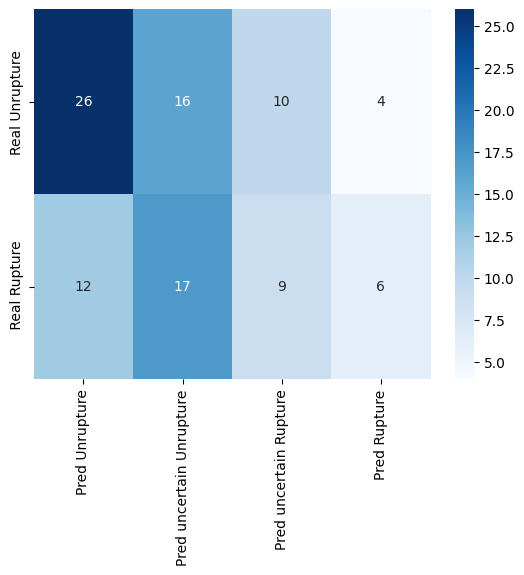

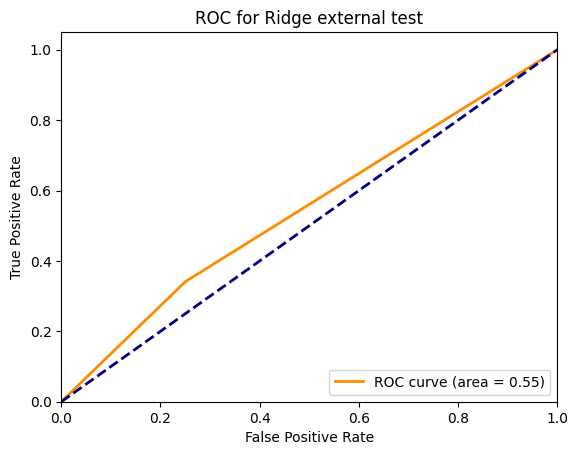

In [13]:
data_predictions_raw = ridge_reg.predict(data_test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(data_test_target))
print_values_advance( list(data_test_target), data_predictions,name="Ridge external test")

show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "Ridge external test")

# Logistic Regression

Logistic internal test set Accuracy: 0.7165354330708661
Logistic internal test set F1 score: 0.5384615384615385
Logistic internal test set RMSE: 0.5324139056496683
Logistic internal test set Rupture Recall: 0.525
Logistic internal test set Rupture Precision: 0.5526315789473685
Logistic internal test set UnRupture Recall: 0.8045977011494253
Logistic internal test set UnRupture Precision: 0.7865168539325843


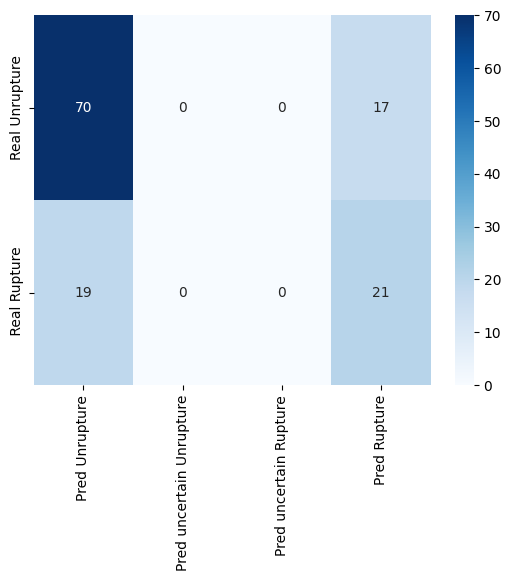

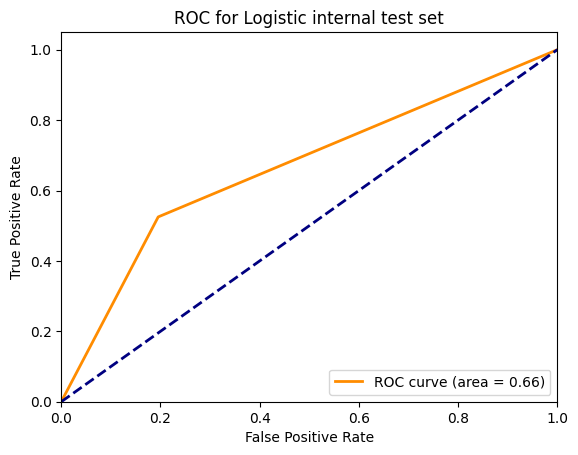

In [14]:
from sklearn.linear_model import LogisticRegression
#L1
logreg = LogisticRegression(penalty='l1', solver='liblinear')

logreg.fit(train_prepared,train_set_target)

data_predictions_raw = logreg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw)

print_values_advance( list(test_set_target), data_predictions,name="Logistic internal test set")
show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "Logistic internal test set")

Logistic external test set Accuracy: 0.59
Logistic external test set F1 score: 0.4675324675324675
Logistic external test set RMSE: 0.6403124237432849
Logistic external test set Rupture Recall: 0.4090909090909091
Logistic external test set Rupture Precision: 0.5454545454545454
Logistic external test set UnRupture Recall: 0.7321428571428571
Logistic external test set UnRupture Precision: 0.6119402985074627


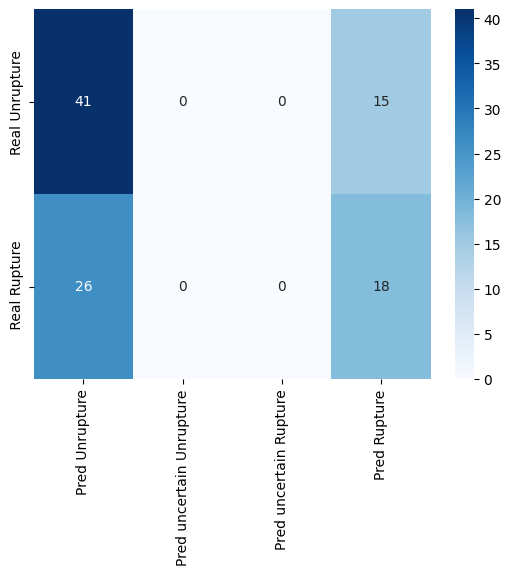

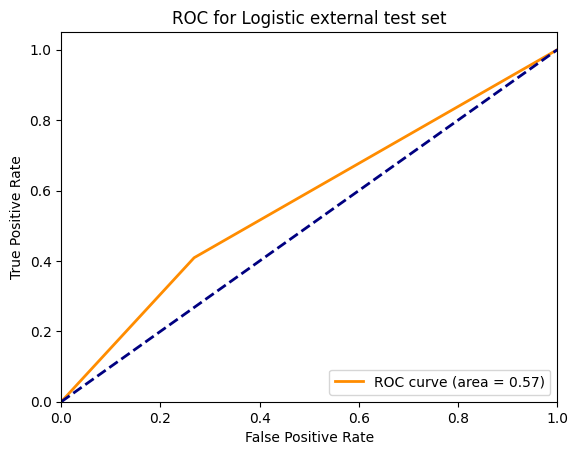

In [15]:
data_predictions_raw = logreg.predict(data_test_prepared)
data_predictions = prediction_conv(data_predictions_raw)

print_values_advance( list(data_test_target), data_predictions,name="Logistic external test set")
show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "Logistic external test set")

# Random Tree

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Random Tree Regressor internal test Accuracy: 0.7716535433070866
Random Tree Regressor internal test F1 score: 0.5797101449275363
Random Tree Regressor internal test RMSE: 0.4778561045889373
Random Tree Regressor internal test Rupture Recall: 0.5
Random Tree Regressor internal test Rupture Precision: 0.6896551724137931
Random Tree Regressor internal test UnRupture Recall: 0.896551724137931
Random Tree Regressor internal test UnRupture Precision: 0.7959183673469388


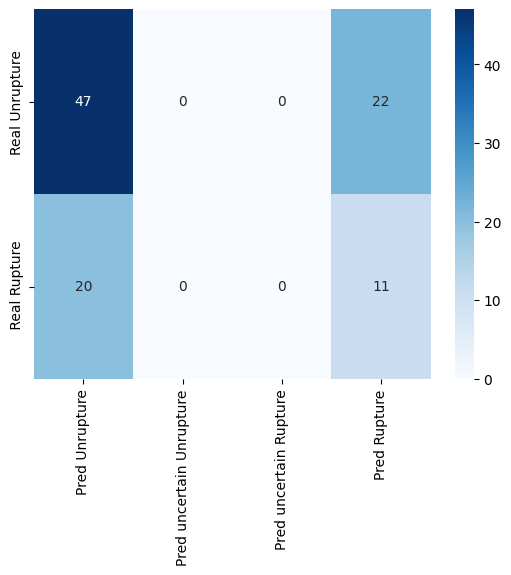

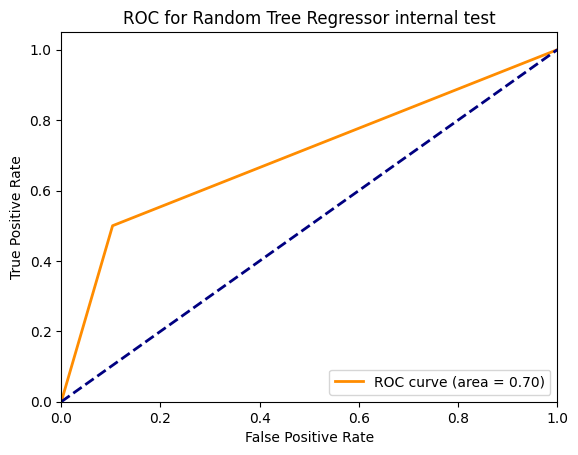

In [16]:

forest_reg=RandomForestRegressor()
#find estimator for random forest regression
param_grid  = [{'n_estimators': [470,430],'max_features':[1,23, 27]}, 
               {'bootstrap': [False],'n_estimators':[30],'max_features':[8]}]


grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error', verbose = 1)
grid_search.fit(train_prepared,train_set_target)

RT_prediction_raws = grid_search.predict(test_prepared)
data_predictions = prediction_conv(RT_prediction_raws,value=0.5)

print_values_advance( list(test_set_target), data_predictions,name="Random Tree Regressor internal test")
show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "Random Tree Regressor internal test")

Random Tree Regressor external test Accuracy: 0.58
Random Tree Regressor external test F1 score: 0.3636363636363636
Random Tree Regressor external test RMSE: 0.648074069840786
Random Tree Regressor external test Rupture Recall: 0.2727272727272727
Random Tree Regressor external test Rupture Precision: 0.5454545454545454
Random Tree Regressor external test UnRupture Recall: 0.8214285714285714
Random Tree Regressor external test UnRupture Precision: 0.5897435897435898


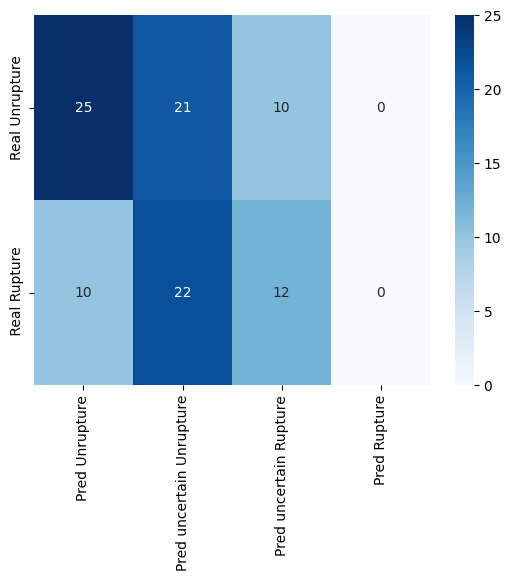

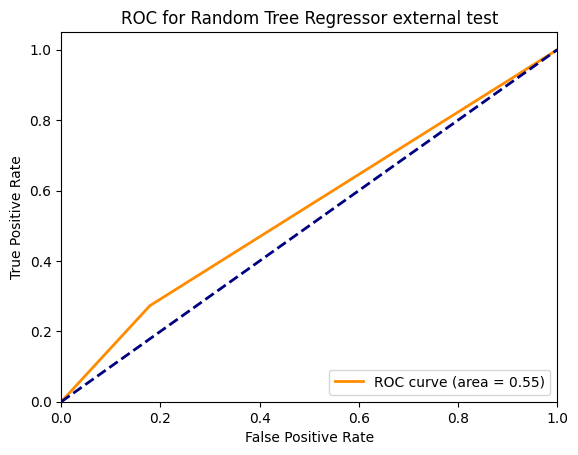

In [17]:
data_predictions_raw = grid_search.predict(data_test_prepared)
data_predictions = prediction_conv(data_predictions_raw)

print_values_advance( list(data_test_target), data_predictions,name="Random Tree Regressor external test")
show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "Random Tree Regressor external test")

# random forest

Random forest Classifier internal test Accuracy: 0.7559055118110236
Random forest Classifier internal test F1 score: 0.5866666666666667
Random forest Classifier internal test RMSE: 0.4940591950252281
Random forest Classifier internal test Rupture Recall: 0.55
Random forest Classifier internal test Rupture Precision: 0.6285714285714286
Random forest Classifier internal test UnRupture Recall: 0.8505747126436781
Random forest Classifier internal test UnRupture Precision: 0.8043478260869565


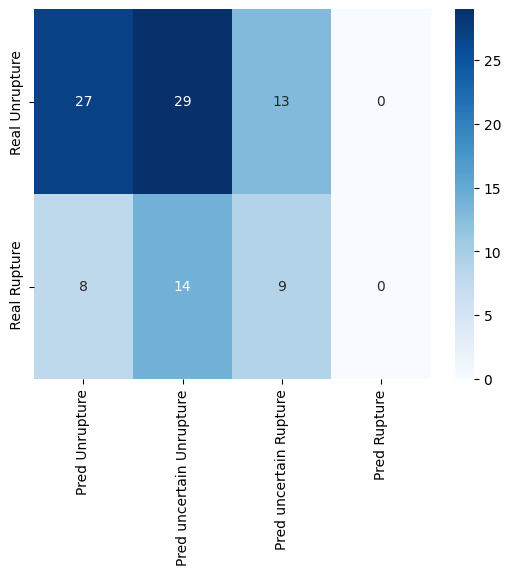

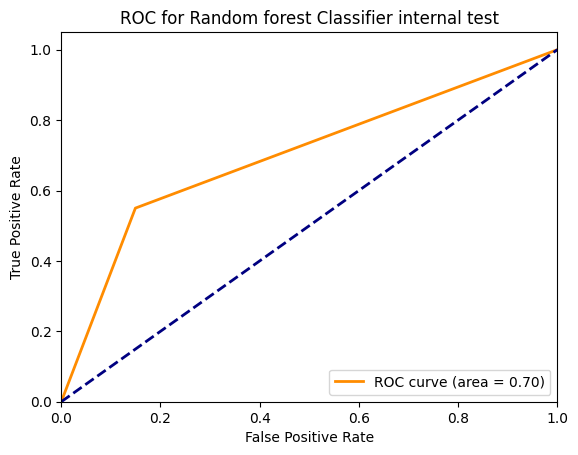

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest_reg= RandomForestClassifier(n_estimators=100, random_state=42)
forest_reg.fit(train_prepared,train_set_target)

RT_predictions_raw = forest_reg.predict(test_prepared)
data_predictions = prediction_conv(RT_predictions_raw,value=0.5)

print_values_advance( list(test_set_target), data_predictions,name="Random forest Classifier internal test")
show_cm_ml(data_predictions_raw, test_set_target)
draw_ROC(list(test_set_target), data_predictions,name = "Random forest Classifier internal test")

Random forest Classifier external test Accuracy: 0.61
Random forest Classifier external test F1 score: 0.4507042253521127
Random forest Classifier external test RMSE: 0.6244997998398398
Random forest Classifier external test Rupture Recall: 0.36363636363636365
Random forest Classifier external test Rupture Precision: 0.5925925925925926
Random forest Classifier external test UnRupture Recall: 0.8035714285714286
Random forest Classifier external test UnRupture Precision: 0.6164383561643836


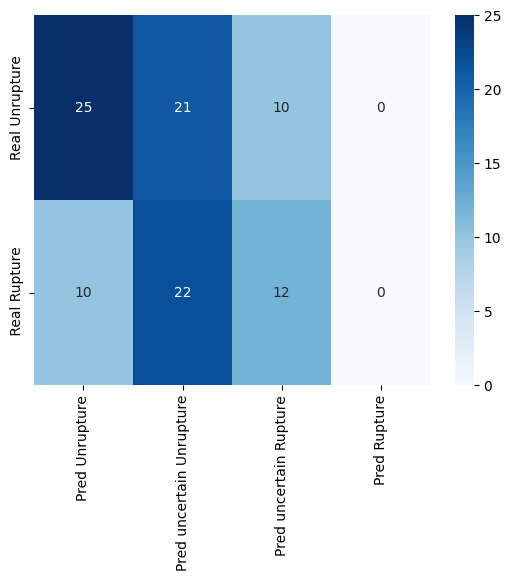

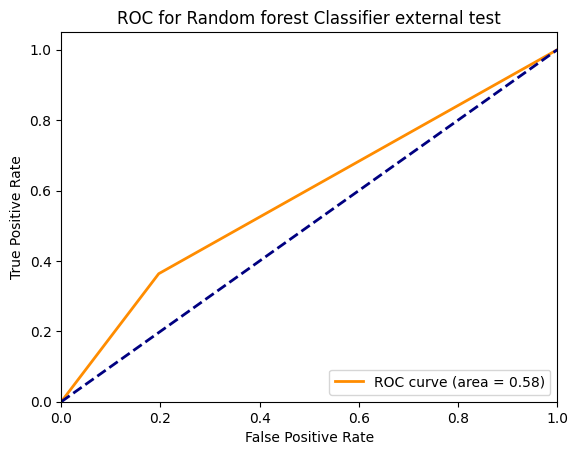

In [19]:
RT_predictions_raw = forest_reg.predict(data_test_prepared)
data_predictions = prediction_conv(RT_predictions_raw,value=0.5)

print_values_advance( list(data_test_target), data_predictions,name="Random forest Classifier external test")
show_cm_ml(data_predictions_raw, data_test_target)
draw_ROC(list(data_test_target), data_predictions,name = "Random forest Classifier external test")